In [1]:
# Import External Packages
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tslearn
from tslearn.clustering import TimeSeriesKMeans

# Importing Custom Functions
import clusteringFns as clf

# Setting Seed for Reproducibility
np.random.seed(2021)

curPath = os.path.abspath(os.getcwd())

In [2]:
## Formatting and subsampling trajectories into a dataframe to be clustered

IDs = ('GS027', 'GS028', 'GS029', 'GS030', 'GS037', 'GS040', 'JC025', 'JC028', 
       'JC029', 'JC039', 'JC044', 'JC047', 'JC048', 'JC052', 'JC057', 'JC059', 
       'JC061', 'JC062', 'JC067')

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_learning"))

signedTraceMatResized, avgTraceMatResized = clf.generateTraceMats(IDs, dataBase)

In [3]:
## Applying time series clustering with various values of k

X = avgTraceMatResized
X = tslearn.utils.to_time_series_dataset(X)

seed = 1008

met = "dtw"

nn = 50
mx = 6

ssd_mat_r = np.zeros((nn, mx))

for ni, n in enumerate(range(0,nn)):
    
    models = []
    km = TimeSeriesKMeans(n_clusters=1, metric=met, max_iter=10)
    km.fit(X)
    models.append(km)
    
    seed = seed + 1
    for k in range(2, mx + 1):
        km = TimeSeriesKMeans(n_clusters=k, metric=met, max_iter=50, random_state=seed)
        km.fit(X)
        models.append(km)

    ssd = []
    nk = []
    for km in models:
        ssd.append(km.inertia_)
        nk.append(km.n_clusters)

    ssd_mat_r[ni,] = ssd

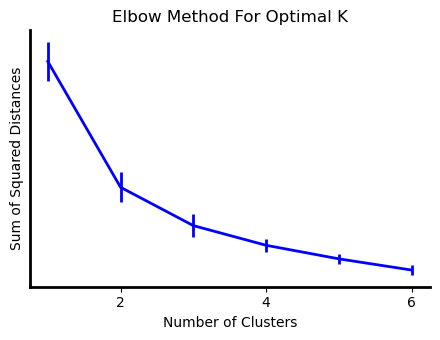

In [4]:
## Visualizing SSD for each k value used

fig, axs = plt.subplots(1,1, figsize=(4.5 , 3.5))

axs.spines[['right', 'top']].set_visible(False)
axs.spines[['left', 'bottom']].set_linewidth(2)
axs.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False, # labels along the bottom edge are off
)

axs.set_xticks((2,4,6))
axs.errorbar(nk, np.mean(ssd_mat_r,0), yerr = np.std(ssd_mat_r,0), fmt = 'b-', linewidth = 2)
axs.set_xlabel('Number of Clusters')
axs.set_ylabel('Sum of Squared Distances')
axs.set_title('Elbow Method For Optimal K')

plt.tight_layout()
plt.show()

In [5]:
## Determining which mice are in stable clusters at k = 2

X = avgTraceMatResized
X = tslearn.utils.to_time_series_dataset(X)

seed = 1008

met = "dtw"

clusterDat = np.zeros((19,19))

nr = 100

ks = np.ones((1,nr)) + 1
ks = np.squeeze(ks)

for i, k in enumerate(ks):

    km = TimeSeriesKMeans(n_clusters = 2, metric=met, max_iter=50, random_state=seed + i)
    km.fit(X)
    x_pred = km.predict(X)

    for ix in range(0,19):
        for iy in range(0,19):
            if x_pred[ix] == x_pred[iy]:
                clusterDat[ix,iy] += 1

clusterDat = clusterDat/nr
clusterDat = pd.DataFrame(clusterDat, columns=IDs, index = IDs)

d = [0,0,0]

for n in range(0,19):
    temp = np.array(clusterDat.iloc[n,:])
    temp = np.delete(temp,[n,])
    
    h = np.histogram(temp,[0,0.3, 0.7, 1])
    d = np.vstack([d,h[0]])

d = d[1:]
d = pd.DataFrame(d, columns = ['Not In Same Cluster', 'Inconsistent', 'In Same Cluster'], index = IDs)

print(d)

       Not In Same Cluster  Inconsistent  In Same Cluster
GS027                    8             2                8
GS028                    8             2                8
GS029                    8             2                8
GS030                    8             2                8
GS037                    9             2                7
GS040                    9             2                7
JC025                    8             2                8
JC028                    9             2                7
JC029                    9             2                7
JC039                    9             2                7
JC044                    8             2                8
JC047                    9             2                7
JC048                    8             2                8
JC052                    0            17                1
JC057                    8             2                8
JC059                    9             2                7
JC061         